# Coursera Capstone Project

Final Module of IBM Data Science Course - Battle of the Neighborhoods

## 1. Introduction

Recent results show that over 3 million Poles no longer eat meat and 8.4% of Polish adults had followed a vegetarian diet or had eaten only fish but no other meat for a period of time [1]( https://notesfrompoland.com/2020/01/14/almost-40-of-poles-claim-to-be-cutting-back-on-meat-and-8-4-have-quit-completely/). The same report indicates that even people who eat meat want to make an effort to limit their consumption. 
Warsaw, capital of the country was also ranked the 6th most vegan friendly city on the planet [2](https://www.happycow.net/vegtopics/travel/top-vegan-friendly-cities
). Thinking of this, our stakeholder wants to expand this trend to Krakow, and open a vegetarian restaurant in the city, which is one of the largest cities in Poland. 

The advantages of Krakow include the fact that the city attracts tourists with its beauty, unique historic complex and cultural events.
When choosing a place to open a new venue, we should take into considerations a few key aspects, like demographics of people interested in this type of restaurante, their income, where they usually live across the city and also real state prices for our business. We also need to know the density of other restaurantes and other restaurantes similar to ours. 
Considering that the analysis in the scope of our initial research relies on free available information and constraints imposed by the Foursquare API, used to track the nearby venues for the district in the city, we will limit our analysis to a few key points:
- Population in each district
- Number of restaurants per district and
- Number of vegetarian restaurants already in the area

## Import relevant packages

In [41]:
import numpy as np
import pandas as pd 
import bs4 as bs
import urllib.request
from bs4 import BeautifulSoup


# pip install geocoder
# !pip install geopy
# pip install folium==0.5.0
import requests  # library to handle requests
import pandas as pd 
import numpy as np 
import random 

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
# plotting library
import folium 
import geocoder

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

## 2. Data

For this preliminary analysis we will consider the following set of data:
- The list of 18 districts in the Krakow area and their coordinates. Information available in the district descriptions in [3](https://en.wikipedia.org/wiki/Districts_of_Krak%C3%B3w)
- Population and population density in each district [4](https://www.bip.krakow.pl/zalaczniki/dokumenty/n/253681/karta)
- Number of restaurantes within a certain radius from each district. This will be limited to the free information from Foursquare API
- Number of vegetarian restaurants already in each district

In the following sections we will use the Foursquare API to search the venues in each district and to sort the total number of restaurants and total number of vegetarian or vegan restaurants in each district. Using this in comparison to the population in each district, we apply an unsupervised learning technic (KMeans) to cluster the districts with regards to our feature selection in order to help us to assess the best neighborhood for the new restaurant. 

### 2.1. Initial set of data

Krakow has 4 distinct areas with a total of 18 districts. Our first step is to get the population, area (in $km^2$) and density of population (number of people per $km^2$). This data was available in [4](https://www.bip.krakow.pl/zalaczniki/dokumenty/n/253681/karta). We also have available in Wikepedia the latitude and longitude for each district, which we can use to produce the following table:

In [146]:
# Load the data
df = pd.read_csv('capstone_data.csv', sep=';')
df.head()

,Region,District,Population,Area,Density of population,Latitude,Longitude
0,Śródmieście,Stare Miasto,31359,5568,5632,50.061389,19.937222
1,Śródmieście,Grzegórzki,29474,5845,5042,50.056611,19.953278
2,Śródmieście,Prądnik Czerwony,46627,6438,7243,50.083231,19.968844
3,Krowodrza,Prądnik Biały,70647,23419,3017,50.099239,19.906303
4,Krowodrza,Krowodrza,30223,5619,5379,50.066667,19.916667


Getting the coordinates for Krakow

In [12]:
address = 'Krakow'
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Krakow are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Krakow are 50.0469432, 19.997153435836697.


We can see the districts with regards to the population density in each one of them

In [17]:
# using latitude and longitude values
map_krakow = folium.Map(location=[latitude, longitude], zoom_start=10)
density_total = df['Density of population'].sum()
# add markers to map
for lat, lng, region, district, density in zip(df['Latitude'], df['Longitude'], df['Region'], df['District'], df['Density of population']):
    label = '{}, {}'.format(district, region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=(density/density_total)*100 + 10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_krakow)  
map_krakow

### 2.2. Using Foursquare API
Now let's explore the venues in Krakow. First define Foursquare Credentials and Version

In [18]:
# Getting foursquare api credentials
CLIENT_ID = '1DKCMFNRGF0PR1MYIXG4WP4TR5PMFDELAGXKHC2240ONF2NC' # your Foursquare ID
CLIENT_SECRET = 'BV2DXQKVBI52CYX5P2HZRKGA4NTI0SXQ33MJNYI15DMXCPN2' # your Foursquare Secret
ACCESS_TOKEN = 'ADFEPBCCUAVQAGYZYAILCI1GDQQDT0G0H1UH2QWQIXOZ54GY' # your FourSquare Access Token
VERSION = '20210604'


Let's create a function to get the nearby venues to all the neighborhoods in Krakow

In [19]:
LIMIT = 500
radius = 2000

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we create a new variable, to store the nearby venues for Krakow

In [147]:
krakow_venues = getNearbyVenues(names=df['District'],
                                  latitudes=df['Latitude'],
                                  longitudes=df['Longitude'])

Stare Miasto
Grzegórzki
Prądnik Czerwony
Prądnik Biały
Krowodrza
Bronowice
Zwierzyniec
Dębnik
Łagiewniki-Borek Fałęcki
Swoszowice
Podgórze Duchackie
Bieżanów-Prokocim
Podgórze
Czyżyny
Mistrzejowice
Bieńczyce
Wzgórza Krzesławickie
Nowa Huta


Let's check the size of our dataframe

In [148]:
print(krakow_venues.shape)
krakow_venues.head()

(498, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Stare Miasto,50.061389,19.937222,Rynek Główny,50.061470,19.936192,Plaza
1,Stare Miasto,50.061389,19.937222,Bazylika Mariacka,50.061675,19.939267,Church
2,Stare Miasto,50.061389,19.937222,Frankie's,50.060032,19.939028,Juice Bar
3,Stare Miasto,50.061389,19.937222,Kino Pod Baranami,50.061603,19.935257,Indie Movie Theater
4,Stare Miasto,50.061389,19.937222,Plac Mariacki,50.061368,19.939263,Plaza


Let's check how many venues were returned for each neighborhood

In [150]:
krakow_venues.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Bieńczyce,19,19,19,19,19,19
Bieżanów-Prokocim,5,5,5,5,5,5
Bronowice,7,7,7,7,7,7
Czyżyny,30,30,30,30,30,30
Dębnik,4,4,4,4,4,4
Grzegórzki,100,100,100,100,100,100
Krowodrza,94,94,94,94,94,94
Mistrzejowice,7,7,7,7,7,7
Nowa Huta,22,22,22,22,22,22


Let's find out how many unique categories can be curated from all the returned venues

In [23]:
print('There are {} uniques categories.'.format(len(krakow_venues['Venue Category'].unique())))

There are 135 uniques categories.


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category 

In [26]:
# one hot encoding
krakow_onehot = pd.get_dummies(krakow_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
krakow_onehot['District'] = krakow_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [krakow_onehot.columns[-1]] + list(krakow_onehot.columns[:-1])
krakow_onehot = krakow_onehot[fixed_columns]

krakow_grouped = krakow_onehot.groupby('District').mean().reset_index()
krakow_grouped.head()

,District,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bagel Shop,Bakery,Bar,...,Theater,Theme Park,Toy / Game Store,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Water Park,Wine Bar,Zoo
0,Bieńczyce,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.105263,0.0,0.000000,0.0,0.0,0.0
1,Bieżanów-Prokocim,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
2,Bronowice,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.285714,0.000000,0.0,0.000000,0.0,0.0,0.0
3,Czyżyny,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.033333,0.0,0.000000,0.033333,0.0,0.033333,0.0,0.0,0.0
4,Dębnik,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0


Let's print each neighborhood along with the top 3 most common venues

In [29]:
num_top_venues = 3

for hood in krakow_grouped['District']:
    print("----"+hood+"----")
    temp = krakow_grouped[krakow_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bieńczyce----
                  venue  freq
0           Supermarket  0.21
1  Fast Food Restaurant  0.21
2          Tram Station  0.11


----Bieżanów-Prokocim----
                  venue  freq
0     Convenience Store   0.2
1  Gym / Fitness Center   0.2
2              Platform   0.2


----Bronowice----
           venue  freq
0    Flower Shop  0.29
1  Train Station  0.29
2    Flea Market  0.14


----Czyżyny----
              venue  freq
0          Bus Stop  0.07
1       Supermarket  0.07
2  Department Store  0.07


----Dębnik----
            venue  freq
0  Scenic Lookout  0.25
1      Restaurant  0.25
2     Pizza Place  0.25


----Grzegórzki----
        venue  freq
0         Bar  0.08
1       Hotel  0.07
2  Food Truck  0.06


----Krowodrza----
    venue  freq
0    Café  0.07
1    Park  0.05
2  Bistro  0.04


----Mistrzejowice----
              venue  freq
0      Tram Station  0.29
1              Park  0.14
2  Sushi Restaurant  0.14


----Nowa Huta----
         venue  freq
0         Par

We can see the main 3 venues in each district and also notice that we have restaurants among the top 3 in many districts, including in the more densely populated ones. 

In the next section we will merge the results from Table 1 with all the venues listed in the Foursquare API and select the features we want to use in our analysis. One important note here is that we have a limitation in the number of venues we can get for free with Foursquare, but for the current scope of our assessment (limit = 500) this is enough. 


### 2.3. Data cleaning and feature selection

In [169]:
krakow_restaurants = krakow_venues[(krakow_venues['Venue Category'].str.contains('Vegetarian', regex=False)) |
                 (krakow_venues['Venue Category'].str.contains('Vegan', regex=False))|
                 (krakow_venues['Venue Category'].str.contains('Diner', regex=False))|
                 (krakow_venues['Venue Category'].str.contains('Pizza Place', regex=False))|
                 (krakow_venues['Venue Category'].str.contains('Restaurant', regex=False))]
krakow_restaurants.head()

,index,District,District Latitude,District Longitude,Total Restaurants,Venue Latitude,Venue Longitude,Venue Category
9,9,Stare Miasto,50.061389,19.937222,La grande mamma,50.061230,19.935529,Italian Restaurant
11,11,Stare Miasto,50.061389,19.937222,Pizzatopia,50.062943,19.933834,Pizza Place
13,13,Stare Miasto,50.061389,19.937222,3 Rybki,50.063051,19.936474,Eastern European Restaurant
14,14,Stare Miasto,50.061389,19.937222,Bianca Pasta & Wine,50.061899,19.939741,Italian Restaurant
21,21,Stare Miasto,50.061389,19.937222,La Petite France,50.062825,19.941311,French Restaurant


In [170]:
number_restaurants = krakow_venues[(krakow_venues['Venue Category'].str.contains('Vegetarian', regex=False)) |
                 (krakow_venues['Venue Category'].str.contains('Vegan', regex=False))|
                 (krakow_venues['Venue Category'].str.contains('Diner', regex=False))|
                 (krakow_venues['Venue Category'].str.contains('Pizza Place', regex=False))|
                 (krakow_venues['Venue Category'].str.contains('Restaurant', regex=False))].groupby(['District']).count()

number_restaurants.rename(columns={'Venue':'Total Restaurants'}, inplace=True)
number_restaurants.reset_index(inplace=True)
number_restaurants = number_restaurants.loc[:, ['District', 'Total Restaurants']]
number_restaurants

,District,Total Restaurants
0,Bieńczyce,6
1,Bieżanów-Prokocim,1
2,Czyżyny,5
3,Dębnik,3
4,Grzegórzki,28
5,Krowodrza,22
6,Mistrzejowice,2
7,Nowa Huta,4
8,Podgórze,3
9,Podgórze Duchackie,1


In [153]:
number_veg = krakow_venues[(krakow_venues['Venue Category'].str.contains('Vegetarian', regex=False)) |
                 (krakow_venues['Venue Category'].str.contains('Vegan', regex=False))].groupby(['District']).count()
number_veg.rename(columns={'Venue':'Total Vegetarian'}, inplace=True)
number_veg.reset_index(inplace=True)
number_veg = number_veg.loc[:, ['District', 'Total Vegetarian']]

number_veg

,District,Total Vegetarian
0,Grzegórzki,2
1,Krowodrza,1
2,Stare Miasto,3


In [168]:
df= df.merge(number_restaurants, on='District', how='left')
df = df.merge(number_veg, on='District', how='left')
df = df.fillna(0)
df.head()
df.to_clipboard(sep=',')

In [35]:

df.columns

Index(['Region', 'District', 'Population', 'Area', 'Density of population',
       'Latitude', 'Longitude', 'Total Restaurants', 'Total Vegetarian'],
      dtype='object')

In [155]:

df_cluster = df.loc[:, ['Population', 'Total Restaurants', 'Total Vegetarian', 'Density of population', 'Area']]
#df_cluster['Restaurants/1000 people'] = df['Total Restaurants']/(df['Population']/1000)
#df_cluster['Veg rest/1000 people'] = df['Total Vegetarian']/(df['Population']/1000)
df_cluster['Density of restaurants'] = df['Total Restaurants']/(df['Area'])
df_cluster['Density of veg restaurants'] = df['Total Vegetarian']/(df['Area'])

df_cluster.drop(['Total Restaurants', 'Total Vegetarian', 'Population', 'Area'], axis=1, inplace=True)
df_cluster = df_cluster.values
df_cluster


array([[5.63200000e+03, 5.02873563e-03, 5.38793103e-04],
       [5.04200000e+03, 4.79041916e-03, 3.42172797e-04],
       [7.24300000e+03, 7.76638708e-04, 0.00000000e+00],
       [3.01700000e+03, 2.13501857e-04, 0.00000000e+00],
       [5.37900000e+03, 3.91528742e-03, 1.77967610e-04],
       [2.47700000e+03, 0.00000000e+00, 0.00000000e+00],
       [7.10000000e+02, 6.96112213e-05, 0.00000000e+00],
       [1.33400000e+03, 6.49505293e-05, 0.00000000e+00],
       [2.81800000e+03, 5.54016620e-04, 0.00000000e+00],
       [1.07400000e+03, 3.90563974e-05, 0.00000000e+00],
       [5.63400000e+03, 1.04821803e-04, 0.00000000e+00],
       [3.40100000e+03, 5.41301288e-05, 0.00000000e+00],
       [1.43700000e+03, 1.16881599e-04, 0.00000000e+00],
       [2.41800000e+03, 4.07930162e-04, 0.00000000e+00],
       [9.30400000e+03, 3.57781753e-04, 0.00000000e+00],
       [1.11140000e+04, 1.62206002e-03, 0.00000000e+00],
       [8.48000000e+02, 4.19903422e-05, 0.00000000e+00],
       [7.83000000e+02, 6.11527

In [156]:

from sklearn.preprocessing import StandardScaler
df_cluster = StandardScaler().fit_transform(df_cluster)
df_cluster

array([[ 0.59431351,  2.43316778,  3.31752595],
       [ 0.39527817,  2.28879986,  1.95847882],
       [ 1.13778117, -0.14267754, -0.40663273],
       [-0.28785157, -0.48381591, -0.40663273],
       [ 0.50896446,  1.75866049,  0.82348624],
       [-0.4700195 , -0.61315157, -0.40663273],
       [-1.06611346, -0.57098232, -0.40663273],
       [-0.85560829, -0.57380569, -0.40663273],
       [-0.35498383, -0.27753808, -0.40663273],
       [-0.94331878, -0.5894919 , -0.40663273],
       [ 0.5949882 , -0.54965237, -0.40663273],
       [-0.15830993, -0.58036049, -0.40663273],
       [-0.82086145, -0.54234676, -0.40663273],
       [-0.48992304, -0.36603468, -0.40663273],
       [ 1.83305545, -0.3964137 , -0.40663273],
       [ 2.44365537,  0.36946378, -0.40663273],
       [-1.01955943, -0.58771456, -0.40663273],
       [-1.04148705, -0.57610633, -0.40663273]])

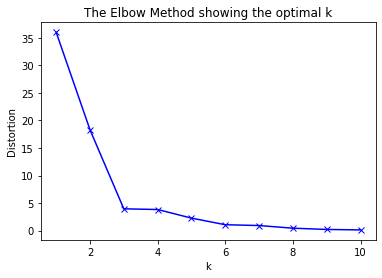

In [157]:
# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

sse = calculate_WSS(df_cluster, 10)

# Plot the elbow
plt.plot(np.arange(1,11), sse, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [158]:
sse

[36.0,
 18.302315445814973,
 3.9519671055782575,
 3.826728592891581,
 2.2675321039966527,
 1.0653434863729923,
 0.9183573225159696,
 0.4386570395956191,
 0.2085306796754251,
 0.12450047377237489]

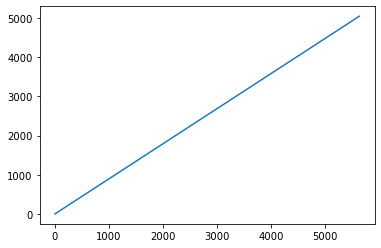

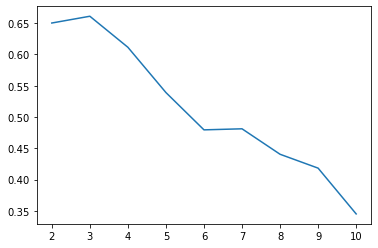

In [159]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(df_cluster)
  labels = kmeans.labels_
  sil.append(silhouette_score(df_cluster, labels, metric = 'euclidean'))
sil
plt.plot(np.arange(2,11), sil)

In [160]:
sil

[0.6502253670464098,
 0.6610580558022996,
 0.6114482299220421,
 0.5390646514076496,
 0.4794124366903584,
 0.48109842882743376,
 0.4403843372651035,
 0.4182024861459635,
 0.3450206265000922]

In [161]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 2, 0, 1, 0, 0, 0, 0, 0], dtype=int32)

In [137]:
#df.drop(['Cluster Labels'], axis=1, inplace=True)

In [162]:
df.insert(0, 'Cluster Labels', kmeans.labels_)
df.head()

,Cluster Labels,Region,District,Population,Area,Density of population,Latitude,Longitude,Total Restaurants,Total Vegetarian
0,1,Śródmieście,Stare Miasto,31359,5568,5632,50.061389,19.937222,28.0,3.0
1,1,Śródmieście,Grzegórzki,29474,5845,5042,50.056611,19.953278,28.0,2.0
2,2,Śródmieście,Prądnik Czerwony,46627,6438,7243,50.083231,19.968844,5.0,0.0
3,0,Krowodrza,Prądnik Biały,70647,23419,3017,50.099239,19.906303,5.0,0.0
4,1,Krowodrza,Krowodrza,30223,5619,5379,50.066667,19.916667,22.0,1.0


In [163]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['District'], df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [111]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, restaurants in zip(df['Latitude'], df['Longitude'], df['District'], df['Cluster Labels'], df['Total Restaurants']/(df['Population']/1000)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=restaurants*4+5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [26]:
df.columns

Index(['Cluster Labels', 'Region', 'District', 'Population', 'Area',
       'Density of population', 'Latitude', 'Longitude', 'Total Restaurants',
       'Total Vegetarian'],
      dtype='object')

In [ ]:
# Fazer grafico com population density e usar isso pra definir... verificar onde os outros restaurantes vegetarianos estao e ver onde estao as universidades
#https://www.statista.com/statistics/1064080/share-of-people-following-a-vegan-diet-in-europe-by-age-group/